In [1]:
import os
import sys
import random
import time
from random import seed, randint
import argparse
import platform
from datetime import datetime
import imp
import numpy as np
import fileinput
from itertools import product
import pandas as pd
from scipy.interpolate import griddata
from scipy.interpolate import interp2d
import seaborn as sns
from os import listdir

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
import matplotlib as mpl
sys.path.insert(0,'/Users/weilu/Research/opt_server/')
# from notebookFunctions import *
# from .. import notebookFunctions
from Bio.PDB.Polypeptide import one_to_three
from Bio.PDB.Polypeptide import three_to_one
from Bio.PDB.PDBParser import PDBParser
from pyCodeLib import *
from small_script.myFunctions import *
from collections import defaultdict
%matplotlib inline
# plt.rcParams['figure.figsize'] = (10,6.180)    #golden ratio
# %matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['figure.figsize'] = np.array([16.18033, 10])    #golden ratio
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({'font.size': 22})

In [3]:
pre = "/Users/weilu/Research/server/may_week2_2020/develop_continuous_fitted_potential/"

In [108]:
def planar_angle(a, b, c):
    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    return angle

def get_dihedral_angle(p0, p1, p2, p3):
    b0 = -1.0*(p1 - p0)
    b1 = p2 - p1
    b2 = p3 - p2

    # normalize b1 so that it does not influence magnitude of vector
    # rejections that come next
    b1 /= np.linalg.norm(b1)

    # vector rejections
    # v = projection of b0 onto plane perpendicular to b1
    #   = b0 minus component that aligns with b1
    # w = projection of b2 onto plane perpendicular to b1
    #   = b2 minus component that aligns with b1
    v = b0 - np.dot(b0, b1)*b1
    w = b2 - np.dot(b2, b1)*b1

    # angle between v and w in a plane is the torsion angle
    # v and w may not be normalized but that's fine since tan is y/x
    x = np.dot(v, w)
    y = np.dot(np.cross(b1, v), w)
    dihedral = np.arctan2(y, x)
    return dihedral

In [180]:
theta = np.load("/Users/weilu/Research/server/may_week2_2020/develop_angle_input_potential/T0958/theta.npz")
omega = np.load("/Users/weilu/Research/server/may_week2_2020/develop_angle_input_potential/T0958/omega.npz")
phi = np.load("/Users/weilu/Research/server/may_week2_2020/develop_angle_input_potential/T0958/phi.npz")


thetaspline = theta["thetaspline"]
omegaspline = omega["omegaspline"]
phispline = phi["phispline"]


omega = "-3.53429174 -3.27249235 -3.01069296 -2.74889357 -2.48709418 -2.2252948\
 -1.96349541 -1.70169602 -1.43989663 -1.17809725 -0.91629786 -0.65449847\
 -0.39269908 -0.13089969  0.13089969  0.39269908  0.65449847  0.91629786\
  1.17809725  1.43989663  1.70169602  1.96349541  2.2252948   2.48709418\
  2.74889357  3.01069296  3.27249235  3.53429174"
theta = "-3.53429174 -3.27249235 -3.01069296 -2.74889357 -2.48709418 -2.2252948\
 -1.96349541 -1.70169602 -1.43989663 -1.17809725 -0.91629786 -0.65449847\
 -0.39269908 -0.13089969  0.13089969  0.39269908  0.65449847  0.91629786\
  1.17809725  1.43989663  1.70169602  1.96349541  2.2252948   2.48709418\
  2.74889357  3.01069296  3.27249235  3.53429174"
phi = "-0.39269908 -0.13089969  0.13089969  0.39269908  0.65449847  0.91629786\
  1.17809725  1.43989663  1.70169602  1.96349541  2.2252948   2.48709418\
  2.74889357  3.01069296  3.27249235  3.53429174"

omega_x = [float(a) for a in omega.split()]
theta_x = [float(a) for a in theta.split()]
phi_x = [float(a) for a in phi.split()]


# spline fit
from scipy.interpolate import interp1d
x = omega_x
spline = omegaspline

num_of_points = 100
n = spline.shape[0]
interaction_list = []
index_list = []

xnew = np.linspace(min(x), max(x), num=num_of_points, endpoint=True)
for i in range(n):
    for j in range(i+1, n):
        if np.alltrue(spline[i][j] == 0):
            continue
        y = spline[i][j]
        f = interp1d(x, y, kind='cubic')
        ynew = f(xnew)
        interaction_list.append(ynew)
        index_list.append([i, j])
index_array = np.array(index_list)
interaction_array = np.array(interaction_list)

In [202]:
def get_omega(res1, res2):
    p0 = res1["CA"].get_coord()
    p1 = res1["CB"].get_coord()
    p2 = res2["CB"].get_coord()
    p3 = res2["CA"].get_coord()
    angle = get_dihedral_angle(p0, p1, p2, p3)
    return angle 
def get_theta(res1, res2):
    p0 = res1["N"].get_coord()
    p1 = res1["CA"].get_coord()
    p2 = res1["CB"].get_coord()
    p3 = res2["CB"].get_coord()
    angle = get_dihedral_angle(p0, p1, p2, p3)
    return angle 
def get_phi(res1, res2):
    a = res1["CA"].get_coord()
    b = res1["CB"].get_coord()
    c = res2["CB"].get_coord()
    angle = planar_angle(a, b, c)
    return angle 
def compute_ml_energy(s, index_array, interaction_array, x, get_function=get_omega, num_of_points=100):

    all_res = list(s.get_residues())
    angle_max = max(x)
    angle_min = min(x)
    d_angle = (angle_max-angle_min)/(num_of_points-1)

    max_angle_index_1 = num_of_points - 2
    energy = 0.0

    for index_pair, interaction in zip(index_array, interaction_array):
        i,j = index_pair
        res1 = all_res[i]
        res2 = all_res[j]
        if res1.resname == "GLY" or res2.resname == "GLY":
            continue
#         r = get_r(all_res, i, j)
#         if r > 20:
#             continue
        angle = get_function(res1, res2)
        if angle < -np.pi or angle > np.pi:
            print(angle, i, j)
        # print(i,j,interaction, r)
        angle_index_1 = int(min(max_angle_index_1, np.floor((angle-angle_min)/d_angle)))
        angle_index_2 = angle_index_1 + 1
        angle_1 = angle_min + d_angle * angle_index_1
        angle_2 = angle_min + d_angle * angle_index_2
        v1 = interaction[angle_index_1]
        v2 = interaction[angle_index_2]
        e = ((v2-v1)*angle+v1*angle_2-v2*angle_1)/(angle_2-angle_1)
        energy += e
    return energy

def compute_ml(s, x, spline, get_function):
    num_of_points = 100
    n = spline.shape[0]
    interaction_list = []
    index_list = []

    xnew = np.linspace(min(x), max(x), num=num_of_points, endpoint=True)
    for i in range(n):
        for j in range(i+1, n):
            if np.alltrue(spline[i][j] == 0):
                continue
            y = spline[i][j]
            f = interp1d(x, y, kind='cubic')
            ynew = f(xnew)
            interaction_list.append(ynew)
            index_list.append([i, j])
    index_array = np.array(index_list)
    interaction_array = np.array(interaction_list)
    
    energy = compute_ml_energy(s, index_array, interaction_array, x, get_function=get_function, num_of_points=num_of_points)
    return energy

In [209]:
pdbFile = "/Users/weilu/Research/server/may_week2_2020/develop_continuous_fitted_potential/6btc.pdb"
s = parser.get_structure("X", pdbFile)
all_res = list(s.get_residues())
# compute_ml_omega_energy(s, index_array, interaction_array, x)

In [206]:
compute_ml(s, x, spline, get_omega)

-5708.720877786699

In [207]:
compute_ml(s, theta_x, thetaspline, get_theta)

-8790.84968782844

In [210]:
compute_ml(s, phi_x, phispline, get_phi)

-15120.48816321016

In [208]:
pdbFile = "/Users/weilu/Research/server/may_week2_2020/develop_continuous_fitted_potential/T0958_init.pdb"
s = parser.get_structure("X", pdbFile)
all_res = list(s.get_residues())
compute_ml(s, theta_x, thetaspline, get_theta)

-749.8926746046429

In [194]:
pdbFile = "/Users/weilu/Research/server/may_week2_2020/develop_continuous_fitted_potential/T0958_init.pdb"
s = parser.get_structure("X", pdbFile)
all_res = list(s.get_residues())
compute_ml_omega_energy(s, index_array, interaction_array, x)

-354.986951235183

In [94]:
res1 = all_res[0]
res2 = all_res[1]

In [ ]:
p0 = res1["CA"].co

In [195]:
pdbFile = "/Users/weilu/Research/server/may_week2_2020/develop_angle_input_potential/6msp.pdb"
s = parser.get_structure("X", pdbFile)[0]
all_res = list(s.get_residues())[20:]
compute_ml_omega_energy(s, index_array, interaction_array, x)

-513.8940115733737

In [176]:
n = len(all_res)
table = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        res1 = all_res[i]
        res2 = all_res[j]
        if res1.resname == "GLY" or res2.resname == "GLY":
            continue
        if i == j:
            continue
        r = get_r(all_res, i, j)
        table[i][j] = r

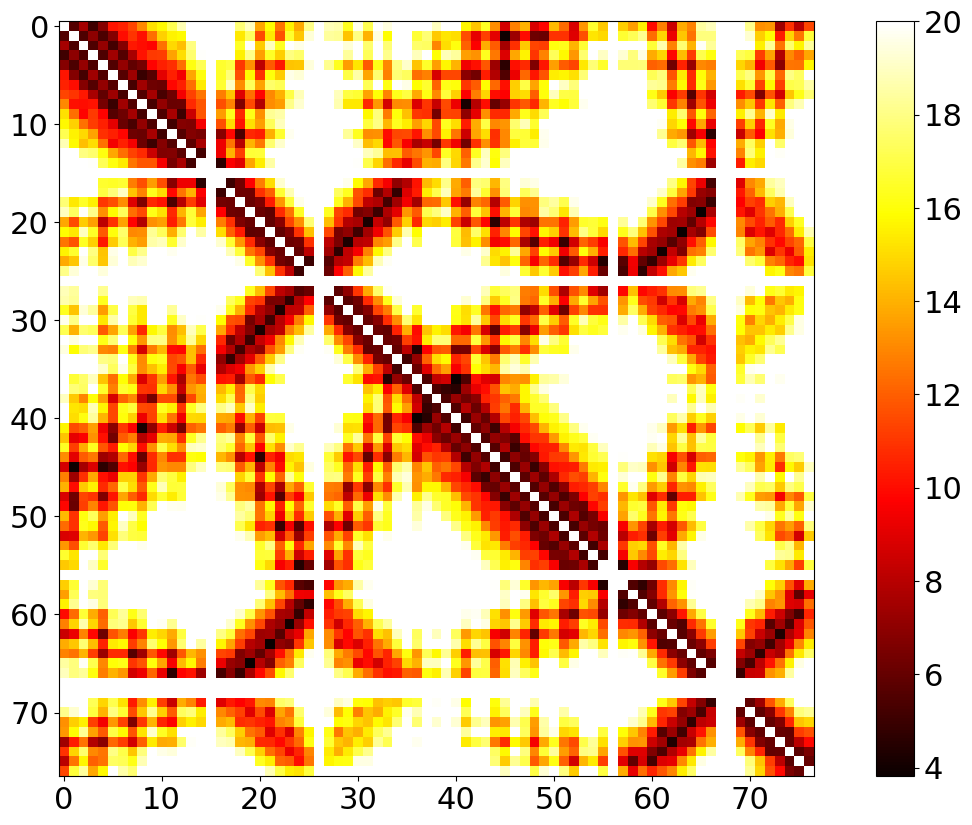

In [177]:
table[table==0] = 20
table[table>20] = 20
plt.imshow(table, cmap="hot")
plt.colorbar()

In [178]:
n = len(all_res)
table = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        res1 = all_res[i]
        res2 = all_res[j]
        if res1.resname == "GLY" or res2.resname == "GLY":
            continue
        if i == j:
            continue
        r = get_r(all_res, i, j)
        if r > 20:
            continue
        angle = get_omega(res1, res2)
        table[i][j] = angle

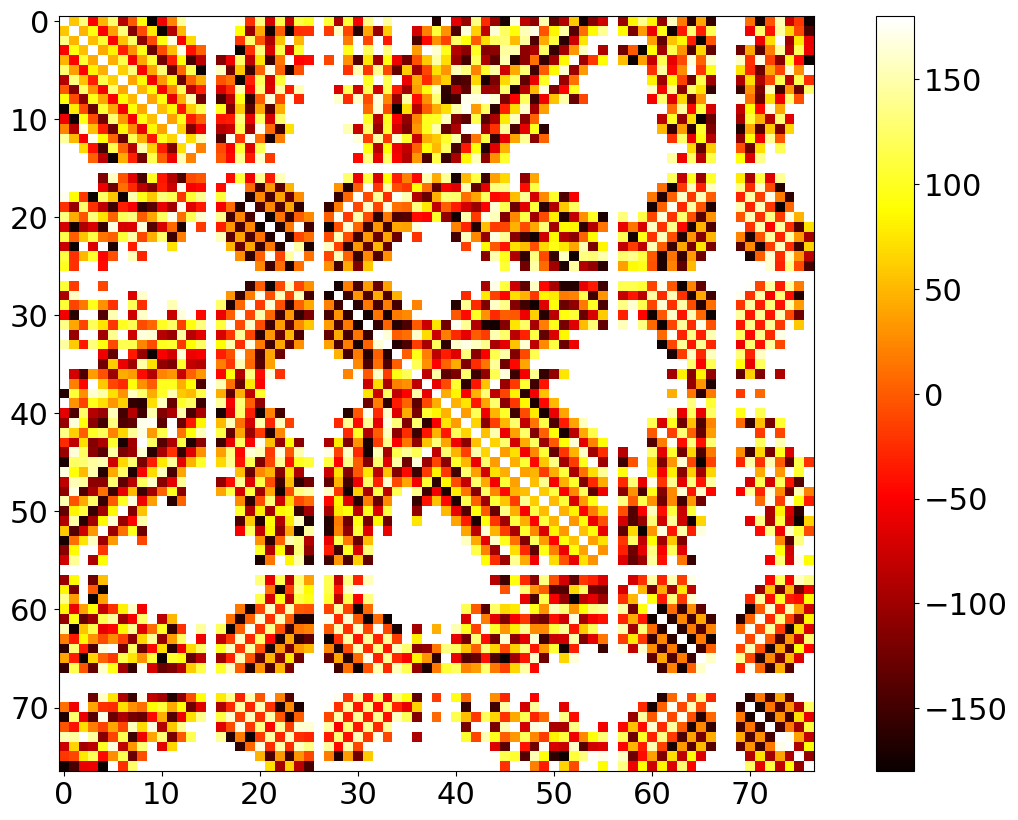

In [179]:
table[table==0] = np.pi
table = table / 3.14 * 180
plt.imshow(table, cmap="hot")
plt.colorbar()

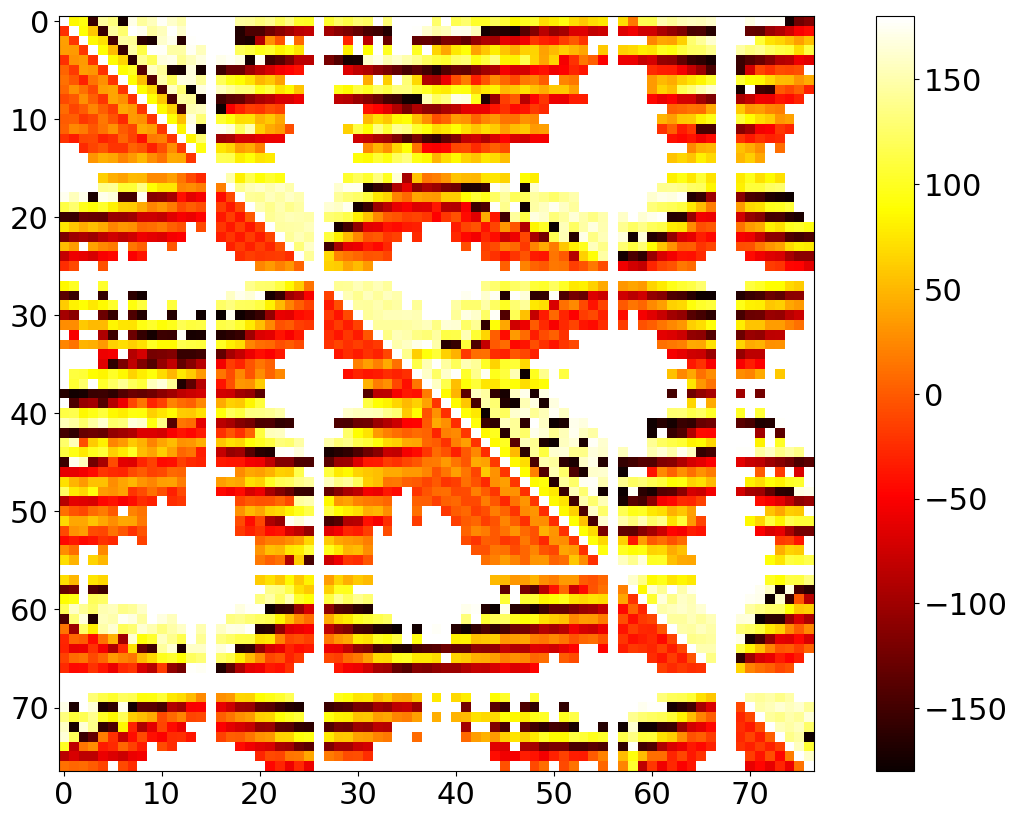

In [198]:
n = len(all_res)
table = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        res1 = all_res[i]
        res2 = all_res[j]
        if res1.resname == "GLY" or res2.resname == "GLY":
            continue
        if i == j:
            continue
        r = get_r(all_res, i, j)
        if r > 20:
            continue
        angle = get_omega(res1, res2)
        table[i][j] = angle
        
table[table==0] = np.pi
table = table / 3.14 * 180
plt.imshow(table, cmap="hot")
plt.colorbar()

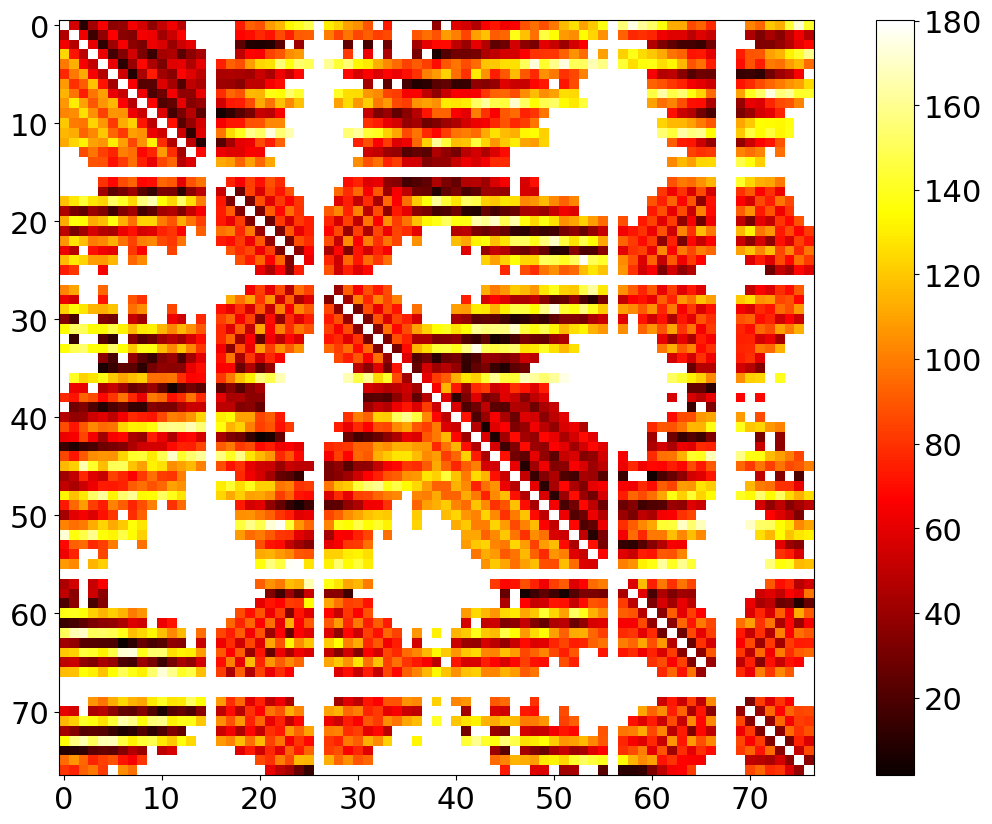

In [201]:
n = len(all_res)
table = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        res1 = all_res[i]
        res2 = all_res[j]
        if res1.resname == "GLY" or res2.resname == "GLY":
            continue
        if i == j:
            continue
        r = get_r(all_res, i, j)
        if r > 20:
            continue
        angle = get_phi(res1, res2)
        table[i][j] = angle
        
table[table==0] = np.pi
table = table / 3.14 * 180
plt.imshow(table, cmap="hot")
plt.colorbar()

In [111]:
get_omega(res1, res2)

-0.68422693

In [112]:
get_omega(res2, res1)

-0.68422693

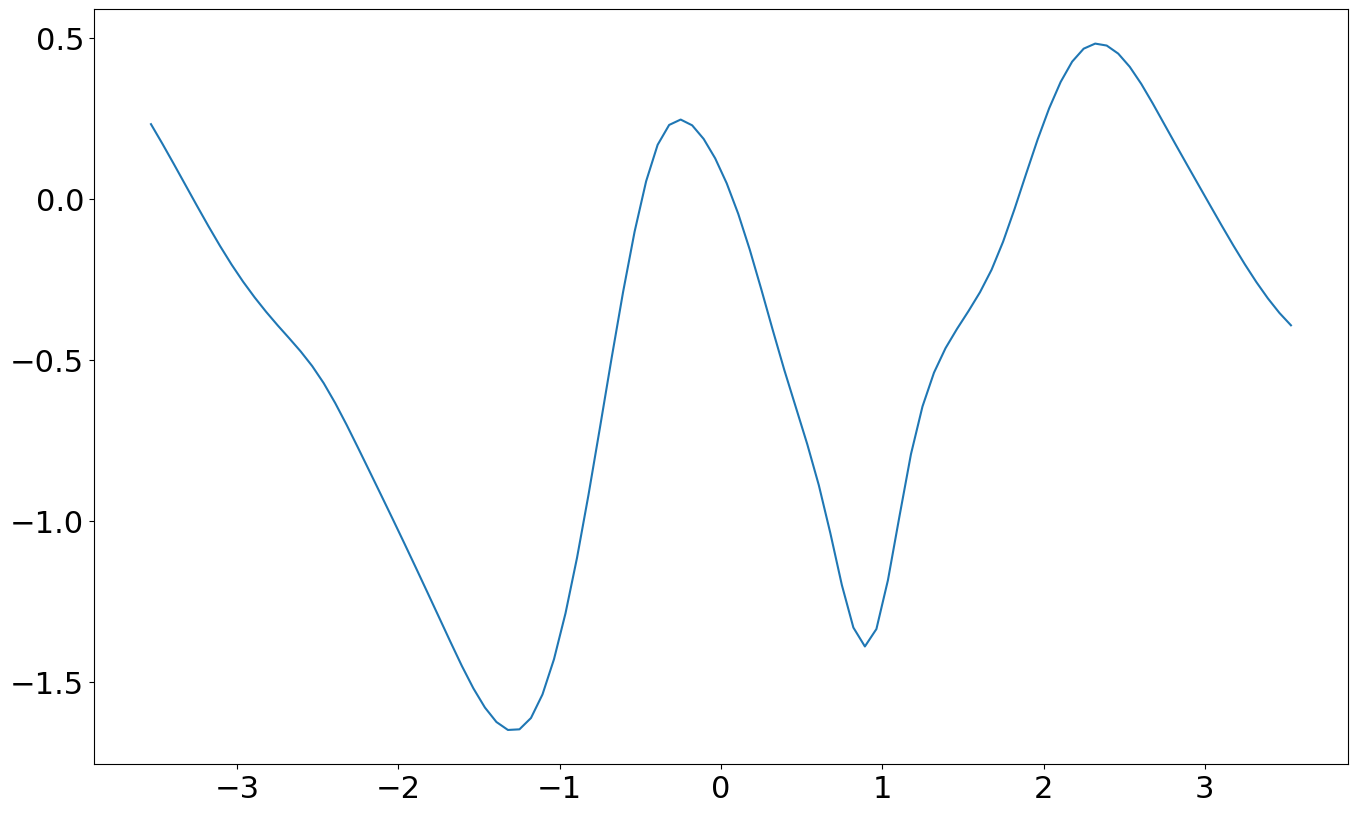

In [121]:
plt.plot(xnew, interaction_array[0])

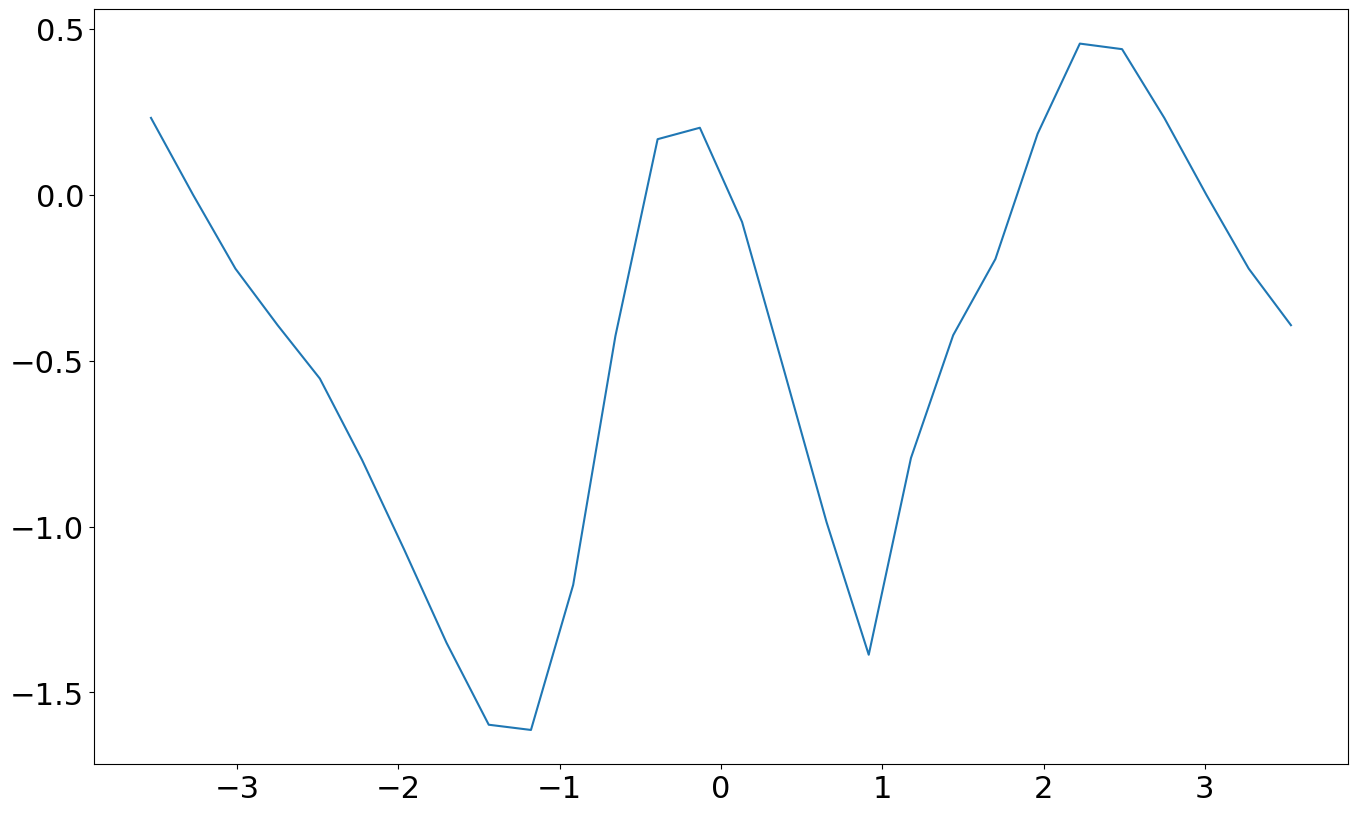

In [123]:
plt.plot(omega_x, omegaspline[0][1])

In [75]:
index_array.shape

(3102, 2)

In [76]:
interaction_array.shape

(3102, 100)

In [92]:
f(-np.pi)

array(-0.13194991)

In [93]:
f(np.pi)

array(-0.13222426)

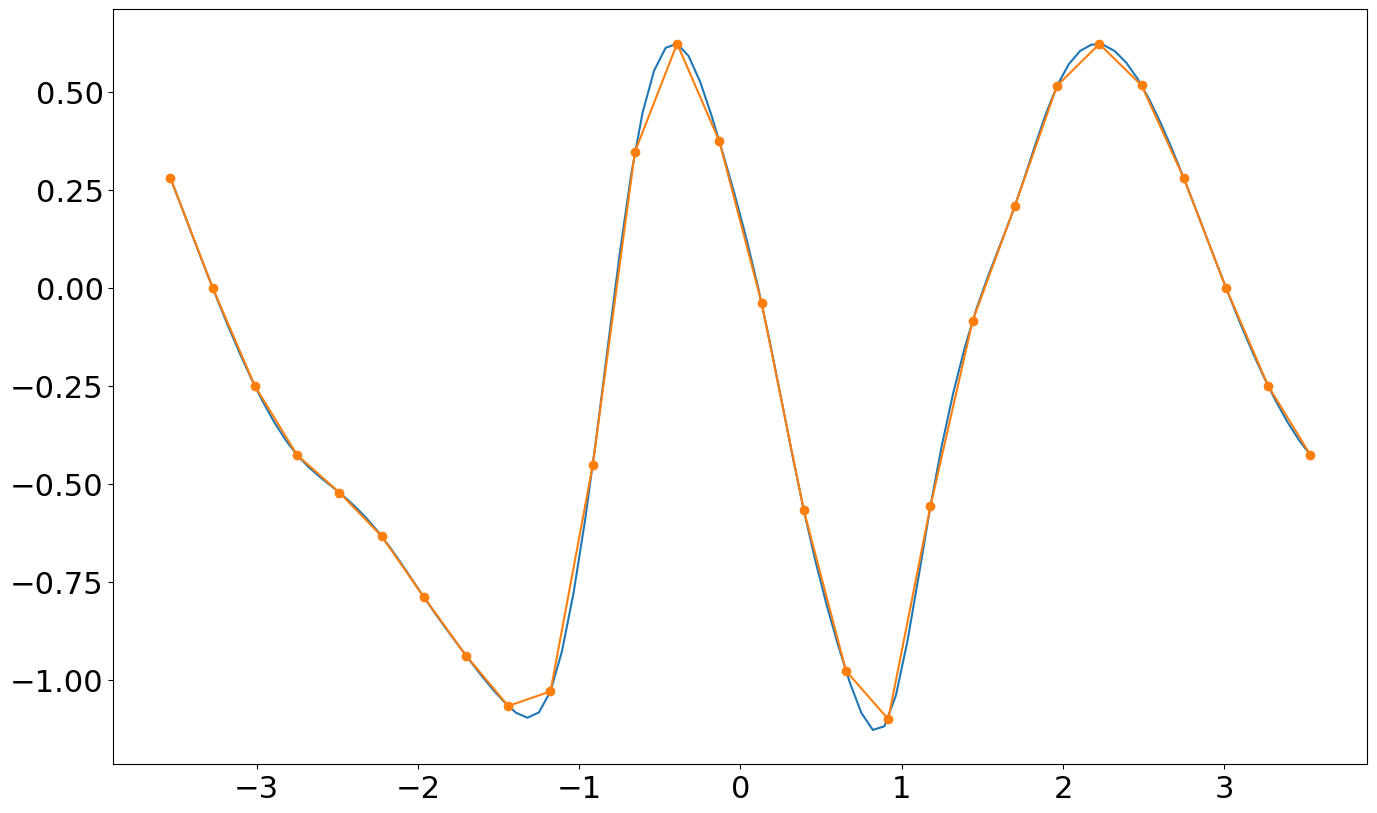

In [85]:
plt.plot(xnew, ynew)
plt.plot(x, y, '-o')

In [79]:
f(3.15)

array(-0.13336129)

In [31]:
def get_cb(res):
    try:
        cb = res["CB"]
    except:
        cb = res["CA"]
    return cb

def get_r(all_res, i, j):
    res1 = all_res[i]
    res2 = all_res[j]
    try:
        cb1 = res1["CB"]
    except:
        cb1 = res1["CA"]
    try:
        cb2 = res2["CB"]
    except:
        cb2 = res2["CA"]
    r = cb1 - cb2
    return r

def compute_machine_learning_energy(s, index_array, interaction_array, num_of_points=100):
    x = [0.0, 2.0, 3.5, 4.25, 4.75, 5.25, 5.75, 6.25, 6.75, 7.25, 7.75, 8.25, 8.75, 9.25, 9.75, 10.25, 10.75, 11.25, 11.75, 12.25, 12.75, 13.25, 13.75, 14.25, 14.75, 15.25, 15.75, 16.25, 16.75, 17.25, 17.75, 18.25, 18.75, 19.25, 19.75]
    
    all_res = list(s.get_residues())
    r_max = max(x)
    r_min = min(x)
    dr = (r_max-r_min)/(num_of_points-1)

    max_r_index_1 = num_of_points - 2
    energy = 0.0

    for index_pair, interaction in zip(index_array, interaction_array):
        i,j = index_pair
        r = get_r(all_res, i, j)
        r = min(r, max(x))
        # print(i,j,interaction, r)
        r_index_1 = int(min(max_r_index_1, np.floor(r/dr)))
        r_index_2 = r_index_1 + 1
        r_1 = r_min + dr * r_index_1
        r_2 = r_min + dr * r_index_2
        v1 = interaction[r_index_1]
        v2 = interaction[r_index_2]
        e = ((v2-v1)*r+v1*r_2-v2*r_1)/(r_2-r_1)
        energy += e
    return energy




In [7]:
parser = PDBParser()
pdbFile = "/Users/weilu/Research/server/may_week2_2020/develop_continuous_fitted_potential/6btc.pdb"
s = parser.get_structure("X", pdbFile)
all_res = list(s.get_residues())
data = np.load(f"{pre}/setups/ml_data.npz")
index_array = data["index_array"]
interaction_array = data["interaction_array"]

print(compute_machine_learning_energy(s, index_array, interaction_array))

-14485.366051576395


In [35]:
a = get_cb(all_res[0]).get_coord()
b = get_cb(all_res[1]).get_coord()
c = get_cb(all_res[2]).get_coord()
ba = a - b
bc = c - b

cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
angle = np.arccos(cosine_angle)

print(np.degrees(angle))

75.294395


In [36]:
angle

1.3141352

In [98]:
"""Praxeolitic formula
1 sqrt, 1 cross product"""

p0 = get_cb(all_res[0]).get_coord()
p1 = get_cb(all_res[1]).get_coord()
p2 = get_cb(all_res[2]).get_coord()
p3 = get_cb(all_res[8]).get_coord()
b0 = -1.0*(p1 - p0)
b1 = p2 - p1
b2 = p3 - p2

# normalize b1 so that it does not influence magnitude of vector
# rejections that come next
b1 /= np.linalg.norm(b1)

# vector rejections
# v = projection of b0 onto plane perpendicular to b1
#   = b0 minus component that aligns with b1
# w = projection of b2 onto plane perpendicular to b1
#   = b2 minus component that aligns with b1
v = b0 - np.dot(b0, b1)*b1
w = b2 - np.dot(b2, b1)*b1

# angle between v and w in a plane is the torsion angle
# v and w may not be normalized but that's fine since tan is y/x
x = np.dot(v, w)
y = np.dot(np.cross(b1, v), w)
dihedral = np.arctan2(y, x)
print(dihedral)

1.3498601


In [104]:
get_dihedral_angle(p2, p3, p0, p1)

0.88651156

In [63]:
parser = PDBParser()
pdbFile = "/Users/weilu/Research/server/may_week2_2020/develop_continuous_fitted_potential/T0958_init.pdb"
s = parser.get_structure("X", pdbFile)
all_res = list(s.get_residues())
data = np.load(f"{pre}/setups/ml_data.npz")
index_array = data["index_array"]
interaction_array = data["interaction_array"]

print(compute_machine_learning_energy(s, index_array, interaction_array))

69045.2639874504


In [17]:
parser = PDBParser()
data = np.load(f"{pre}/setups/ml_data.npz")
index_array = data["index_array"]
interaction_array = data["interaction_array"]
info_ = []
for i in range(1, 100):
    n = str(i).zfill(4)
    pdbFile = f"/Users/weilu/Research/server/may_week2_2020/develop_continuous_fitted_potential/Archive/T0958_init_{n}.pdb"
    s = parser.get_structure("X", pdbFile)
    energy = compute_machine_learning_energy(s, index_array, interaction_array)
    q = compute_Q_from_two_pdb(pdbFileNative, pdbFile)
    info_.append([i, energy, q])


In [18]:
info = pd.DataFrame(info_, columns=["frame", "energy", "Q"])

In [20]:
sp = np.loadtxt("/Users/weilu/Research/server/may_week2_2020/develop_continuous_fitted_potential/spline_potential")

In [43]:
info["sp"] = sp
info["energy_norm"] = info["energy"] / info["energy"].min()
info["sp_norm"] = info["sp"] / info["sp"].min()
info["sp_over_energy"] = info["sp"] / info["energy"]

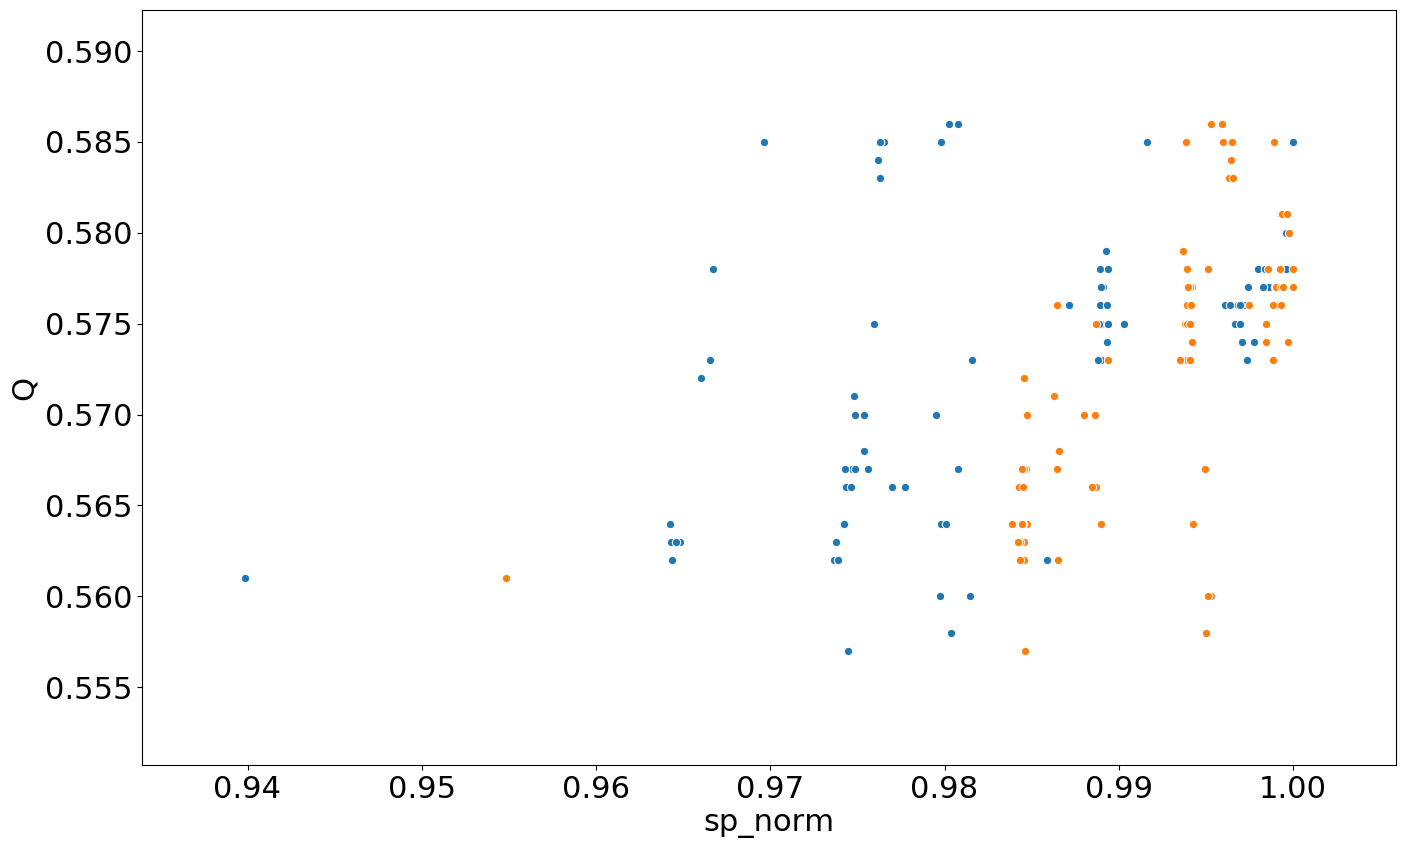

In [58]:
sns.scatterplot("energy_norm", "Q", data=info)
sns.scatterplot("sp_norm", "Q", data=info)

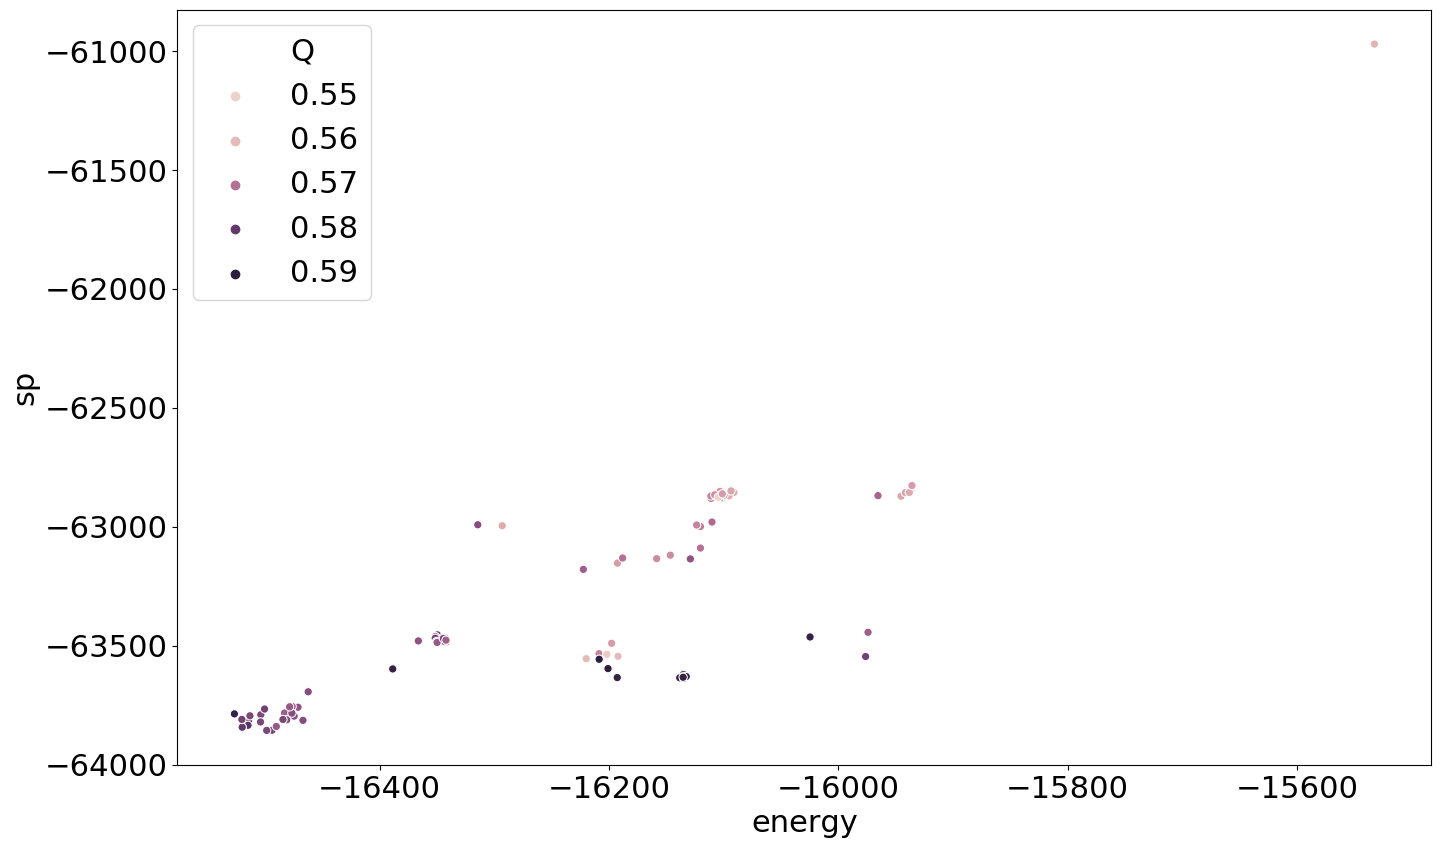

In [60]:
sns.scatterplot("energy", "sp", data=info, hue="Q")

In [48]:
# spline fit
a = np.load(f"{pre}/dist.npz")
distspline = a['distspline']

from scipy.interpolate import interp1d
num_of_points = 100
n = distspline.shape[0]
interaction_list = []
index_list = []
x = [0.0, 2.0, 3.5, 4.25, 4.75, 5.25, 5.75, 6.25, 6.75, 7.25, 7.75, 8.25, 8.75, 9.25, 9.75, 10.25, 10.75, 11.25, 11.75, 12.25, 12.75, 13.25, 13.75, 14.25, 14.75, 15.25, 15.75, 16.25, 16.75, 17.25, 17.75, 18.25, 18.75, 19.25, 19.75]
xnew = np.linspace(min(x), max(x), num=num_of_points, endpoint=True)
for i in range(n):
    for j in range(i+1, n):
        if np.alltrue(distspline[i][j] == 0):
            continue
        y = distspline[i][j]
        f = interp1d(x, y)
        ynew = f(xnew)
        interaction_list.append(ynew)
        index_list.append([i, j])
index_array = np.array(index_list)
interaction_array = np.array(interaction_list)

In [101]:
np.savez(f"{pre}/setups/ml_data.npz", index_array=index_array, interaction_array=interaction_array)

In [51]:
compute_machine_learning_energy(s, index_array, interaction_array, num_of_points=200)

-15059.562419483691

In [71]:
index_array.shape

(3108, 2)

In [70]:
interaction_array.shape

(3108, 100)

In [65]:
ynew

array([10.        ,  9.65263819,  9.30527638,  8.95791457,  8.61055276,
        8.26319095,  7.91582915,  7.56846734,  7.22110553,  6.87374372,
        6.52638191,  6.1790201 ,  5.83165829,  5.48429648,  5.13693467,
        4.78957286,  4.44221106,  4.09484925,  3.74748744,  3.40012563,
        3.05276382,  2.85971524,  2.69430486,  2.52889447,  2.36348409,
        2.1980737 ,  2.03266332,  1.86725293,  1.70184255,  1.53643216,
        1.37102178,  1.20561139,  1.04020101,  0.87479062,  0.70938023,
        0.54396985,  0.04582838, -0.57278469, -1.19139775, -1.81001082,
       -2.42862389, -3.04723696, -3.66585002, -4.26955138, -4.8040198 ,
       -5.33848822, -5.87295664, -6.40742506, -6.89944886, -7.12908775,
       -7.35872664, -7.58836552, -7.81800441, -8.02884153, -8.07281294,
       -8.11678436, -8.16075577, -8.20472719, -8.21527751, -7.73119571,
       -7.24711392, -6.76303212, -6.27895032, -5.79349189, -5.25503344,
       -4.71657499, -4.17811654, -3.63965809, -3.10119964, -2.94

In [61]:
info

,frame,energy,sp,energy_norm,sp_norm,sp_over_energy,Q
0,1,-16493.996544,-63855.6,0.998018,0.999986,3.871445,0.578
1,2,-16388.677335,-63598.1,0.991645,0.995953,3.880612,0.585
2,3,-16293.228071,-62996.3,0.985869,0.986529,3.866410,0.562
3,4,-16102.706257,-62854.8,0.974341,0.984313,3.903369,0.566
4,5,-16471.288314,-63759.1,0.996644,0.998475,3.870924,0.575
...,...,...,...,...,...,...,...
94,95,-16104.758077,-62876.1,0.974466,0.984647,3.904194,0.557
95,96,-15974.143482,-63444.1,0.966562,0.993542,3.971675,0.573
96,97,-15532.544783,-60971.7,0.939842,0.954824,3.925416,0.561
97,98,-16466.963570,-63814.2,0.996382,0.999338,3.875286,0.576


In [95]:

r_max = max(x)
r_min = min(x)
dr = (r_max-r_min)/(num_of_points-1)

max_r_index_1 = num_of_points - 2
energy = 0.0

for index_pair, interaction in zip(index_array, interaction_array):
    i,j = index_pair
    r = get_r(all_res, i, j)
    # print(i,j,interaction, r)
    r_index_1 = int(min(max_r_index_1, np.floor(r/dr)))
    r_index_2 = r_index_1 + 1
    r_1 = r_min + dr * r_index_1
    r_2 = r_min + dr * r_index_2
    v1 = interaction[r_index_1]
    v2 = interaction[r_index_2]
    e = ((v2-v1)*r+v1*r_2-v2*r_1)/(r_2-r_1)
    energy += e
print(energy)

-15039.8605641879


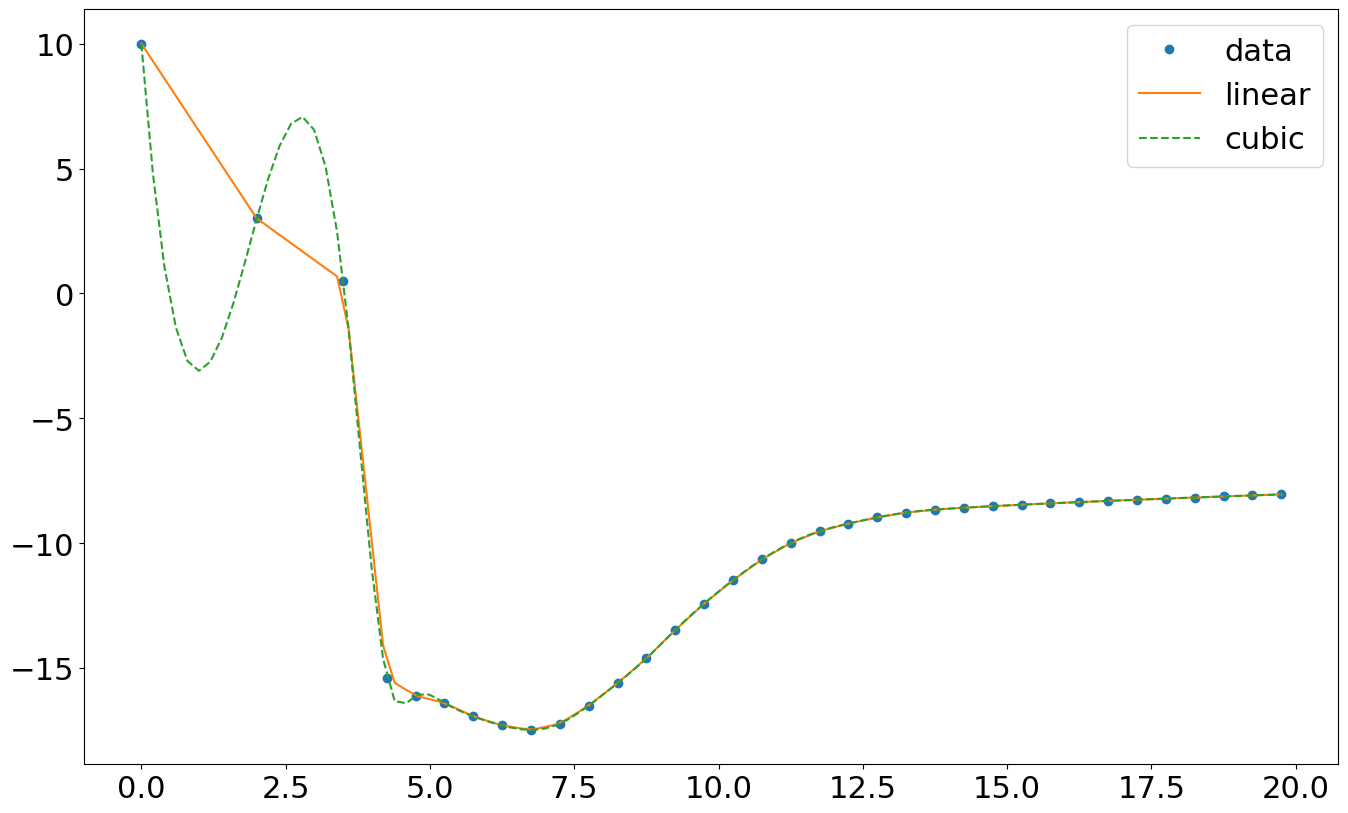

In [57]:

from scipy.interpolate import interp1d
y = distspline[40,48]
f = interp1d(x, y)
f2 = interp1d(x, y, kind='cubic')

xnew = np.linspace(min(x), max(x), num=100, endpoint=True)
plt.plot(x, y, 'o', xnew, f(xnew), '-', xnew, f2(xnew), '--')
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.show()

In [60]:
20/100

0.2

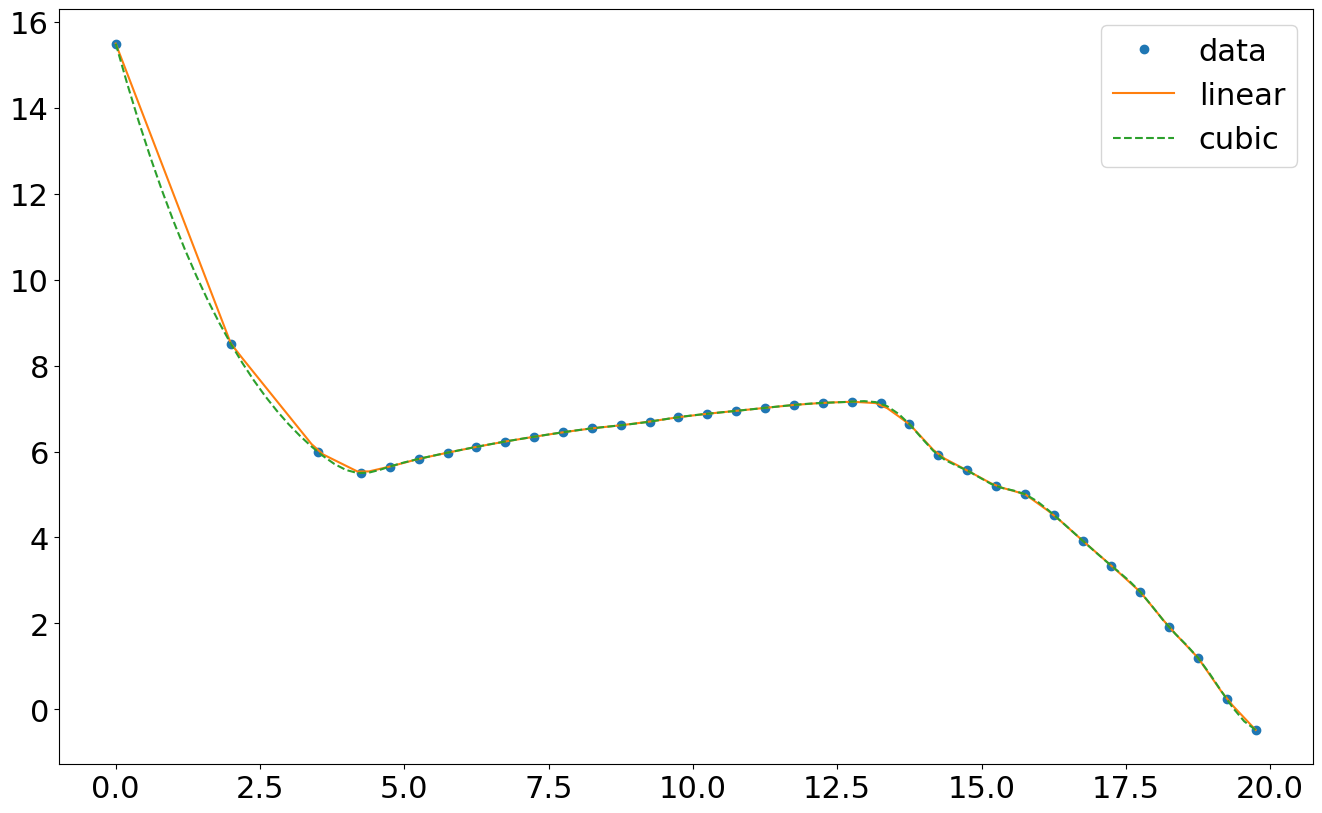

In [62]:

from scipy.interpolate import interp1d
y = distspline[41,54]
f = interp1d(x, y)
f2 = interp1d(x, y, kind='cubic')

xnew = np.linspace(min(x), max(x), num=100, endpoint=True)
plt.plot(x, y, 'o', xnew, f(xnew), '-', xnew, f2(xnew), '--')
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.show()

In [9]:
a.values()

ValuesView(<numpy.lib.npyio.NpzFile object at 0x123950d68>)

In [15]:
distspline.shape

(85, 85, 35)

In [16]:
distspline[0][0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

In [50]:
x = "0.000   2.000   3.500   4.250   4.750   5.250   5.750   6.250   6.750   7.250   7.750   8.250   8.750   9.250   9.750   10.250  10.750  11.250  11.750    12.250  12.750  13.250  13.750  14.250  14.750  15.250  15.750  16.250  16.750  17.250  17.750  18.250  18.750  19.250  19.750"
x = [float(r) for r in x.split()]

In [59]:
print(x)

[0.0, 2.0, 3.5, 4.25, 4.75, 5.25, 5.75, 6.25, 6.75, 7.25, 7.75, 8.25, 8.75, 9.25, 9.75, 10.25, 10.75, 11.25, 11.75, 12.25, 12.75, 13.25, 13.75, 14.25, 14.75, 15.25, 15.75, 16.25, 16.75, 17.25, 17.75, 18.25, 18.75, 19.25, 19.75]


In [23]:
len(x)

35

In [38]:
distspline.min()

-17.946164746766794

In [39]:
distspline.max()

15.493864579789243

In [26]:
dis_sum = np.sum(distspline, axis=2)

In [36]:
np.unravel_index(dis_sum.argmin(), dis_sum.shape)

(40, 48)

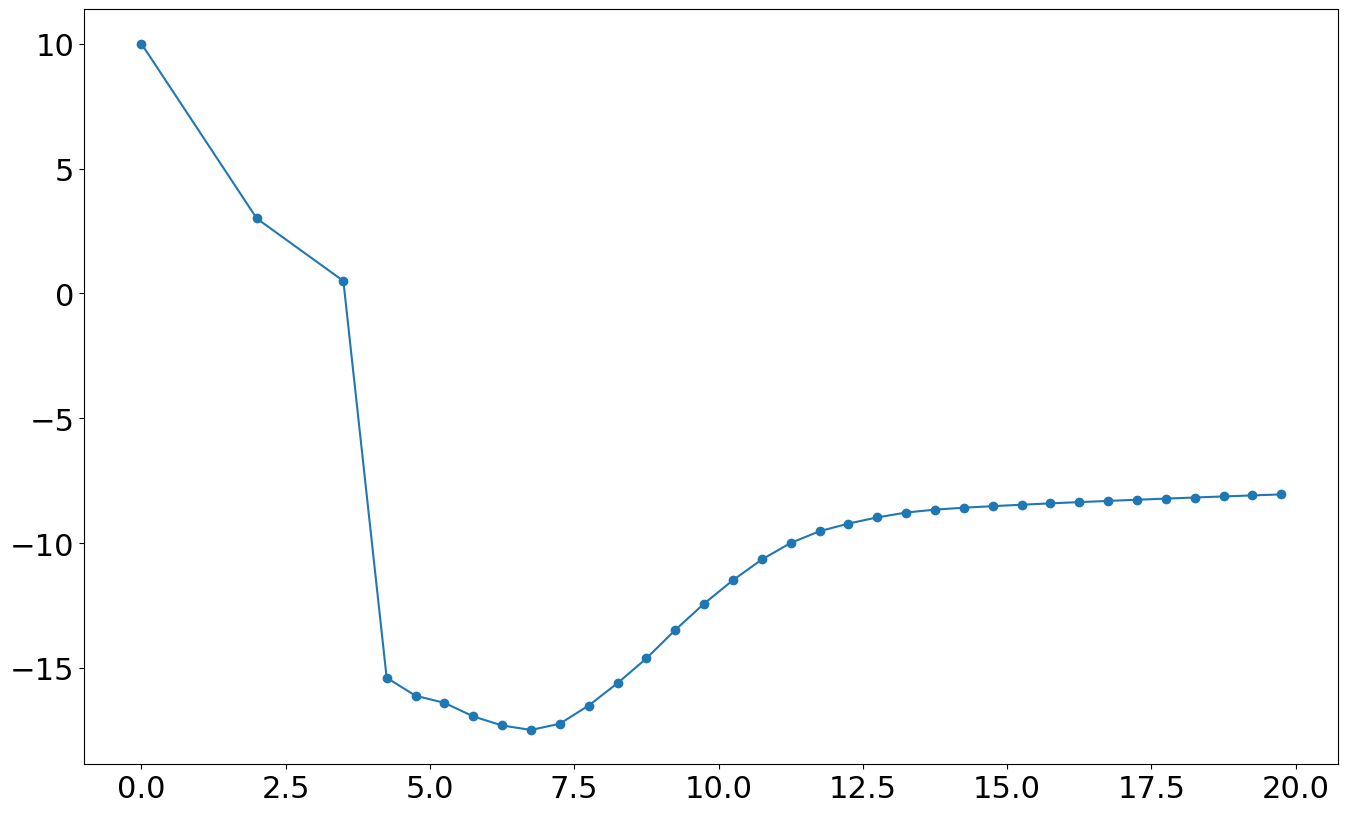

In [55]:
plt.plot(x, distspline[40,48], 'o-')

In [32]:
np.unravel_index(dis_sum.argmax(), dis_sum.shape)

(41, 54)

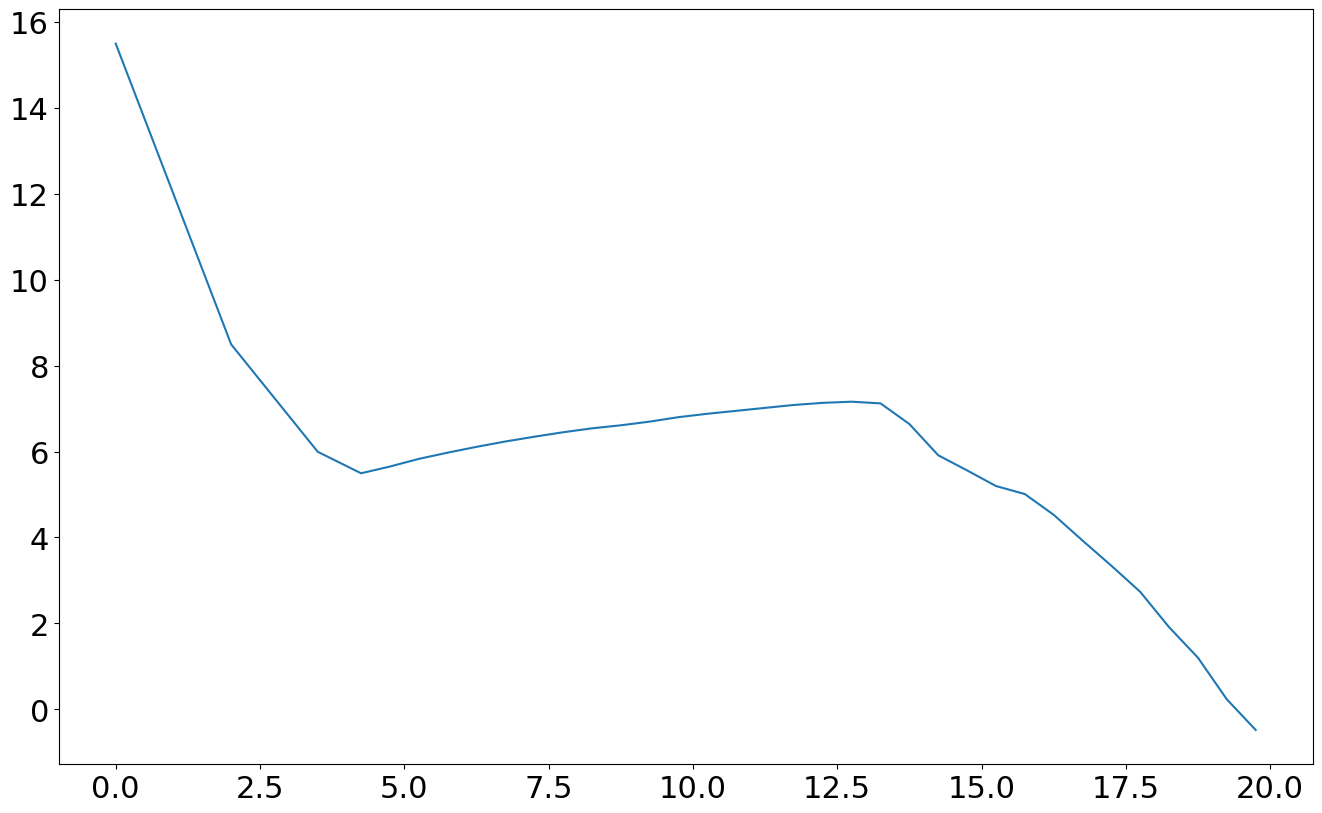

In [35]:
plt.plot(x, distspline[41,54])

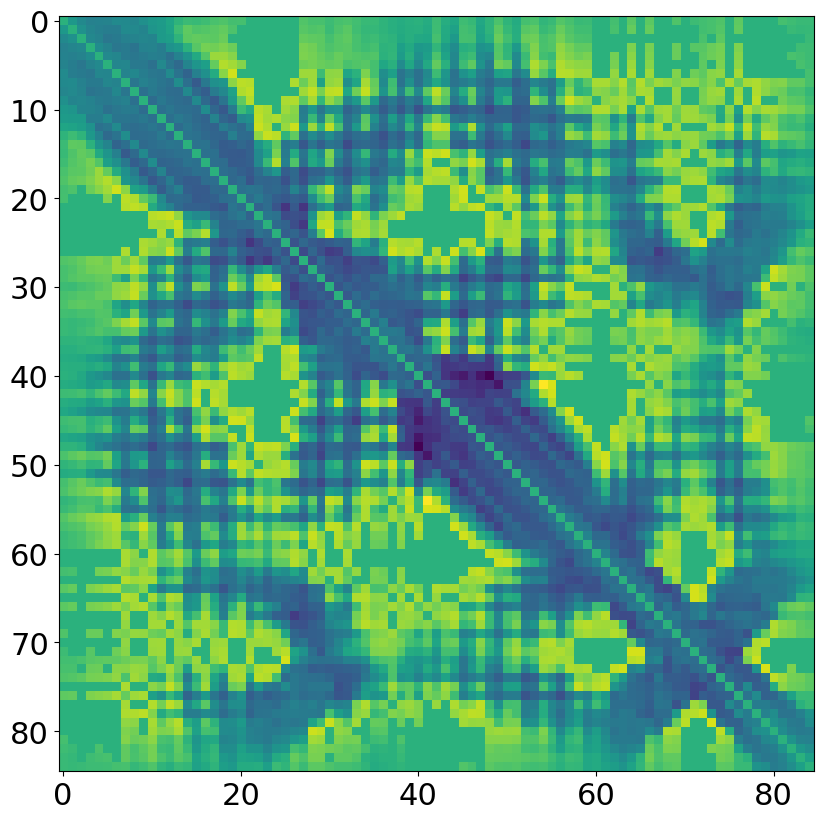

In [27]:
plt.imshow(dis_sum)

In [62]:
theta_sum = thetaspline.sum(axis=2)

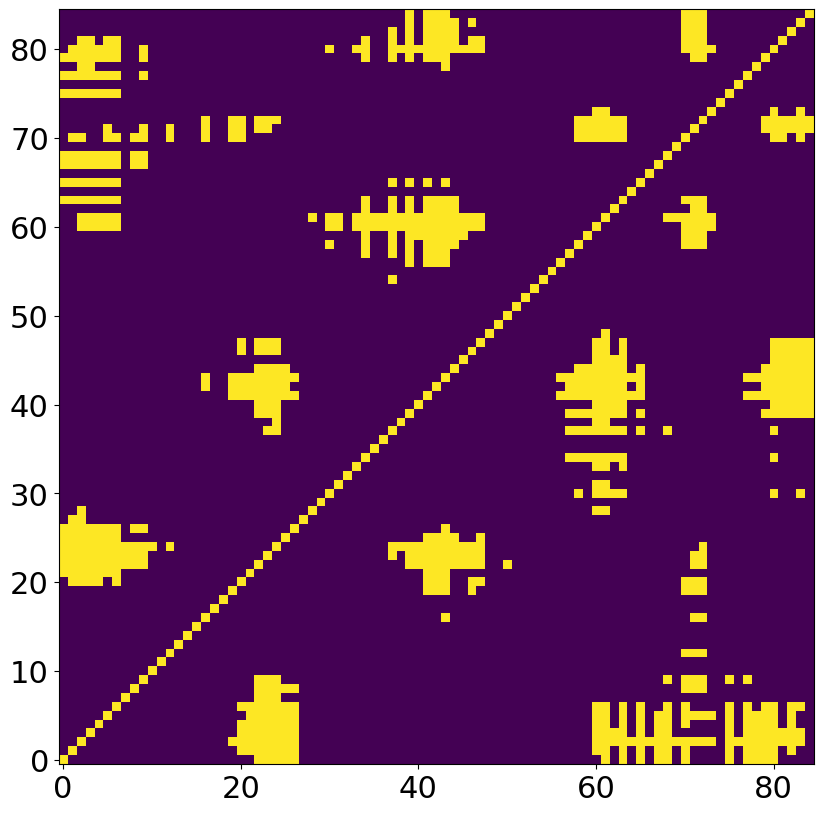

In [63]:
plt.imshow(theta_sum ==0, origin=0)

In [58]:
theta_sum.shape

(85, 85)

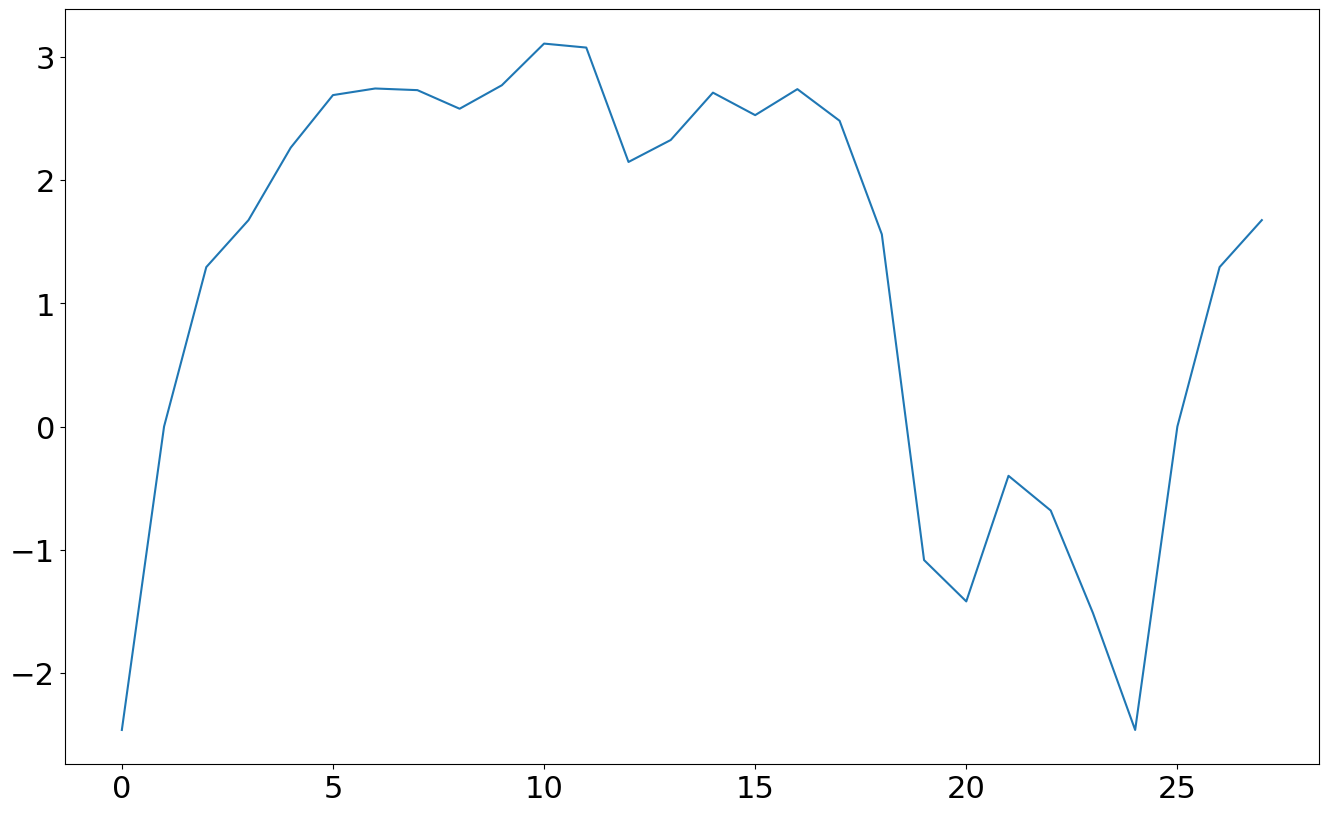

In [18]:
plt.plot(thetaspline[0][1])

In [15]:
theta["thetaspline"].shape

(85, 85, 28)

In [17]:
omega["omegaspline"].shape

(85, 85, 28)

In [19]:
omega["omegaspline"].max()

7.903481960296631

In [ ]:
omega[""]

In [27]:
omega

'-3.53429174 -3.27249235 -3.01069296 -2.74889357 -2.48709418 -2.2252948 -1.96349541 -1.70169602 -1.43989663 -1.17809725 -0.91629786 -0.65449847 -0.39269908 -0.13089969  0.13089969  0.39269908  0.65449847  0.91629786  1.17809725  1.43989663  1.70169602  1.96349541  2.2252948   2.48709418  2.74889357  3.01069296  3.27249235  3.53429174'

In [52]:
thetaspline[-5][61]

array([-2.31968701e-01, -0.00000000e+00, -1.72119457e-02, -2.13365749e-01,
       -2.61769921e-01, -3.18660468e-01, -3.11512947e-01, -2.81041384e-01,
       -2.70385563e-01, -1.39056274e-03,  3.31394225e-01,  5.52532792e-01,
        4.61735427e-01,  1.99742079e-01, -1.04564704e-01, -3.24626416e-01,
       -7.23522246e-01, -1.37166584e+00, -1.94705260e+00, -2.21259761e+00,
       -2.40313911e+00, -2.22530532e+00, -1.56232786e+00, -7.59330153e-01,
       -2.31968701e-01, -0.00000000e+00, -1.72119457e-02, -2.13365749e-01])

In [72]:
len(theta_x)

28

In [65]:
len(phi_x)

16

In [71]:
anglestep = 10
nbins = 28
np.linspace(-np.pi-1.5*anglestep, np.pi+1.5*anglestep, nbins)

array([-18.14159265, -16.79777098, -15.4539493 , -14.11012762,
       -12.76630594, -11.42248426, -10.07866259,  -8.73484091,
        -7.39101923,  -6.04719755,  -4.70337587,  -3.3595542 ,
        -2.01573252,  -0.67191084,   0.67191084,   2.01573252,
         3.3595542 ,   4.70337587,   6.04719755,   7.39101923,
         8.73484091,  10.07866259,  11.42248426,  12.76630594,
        14.11012762,  15.4539493 ,  16.79777098,  18.14159265])

In [66]:
thetaspline.shape

(85, 85, 28)

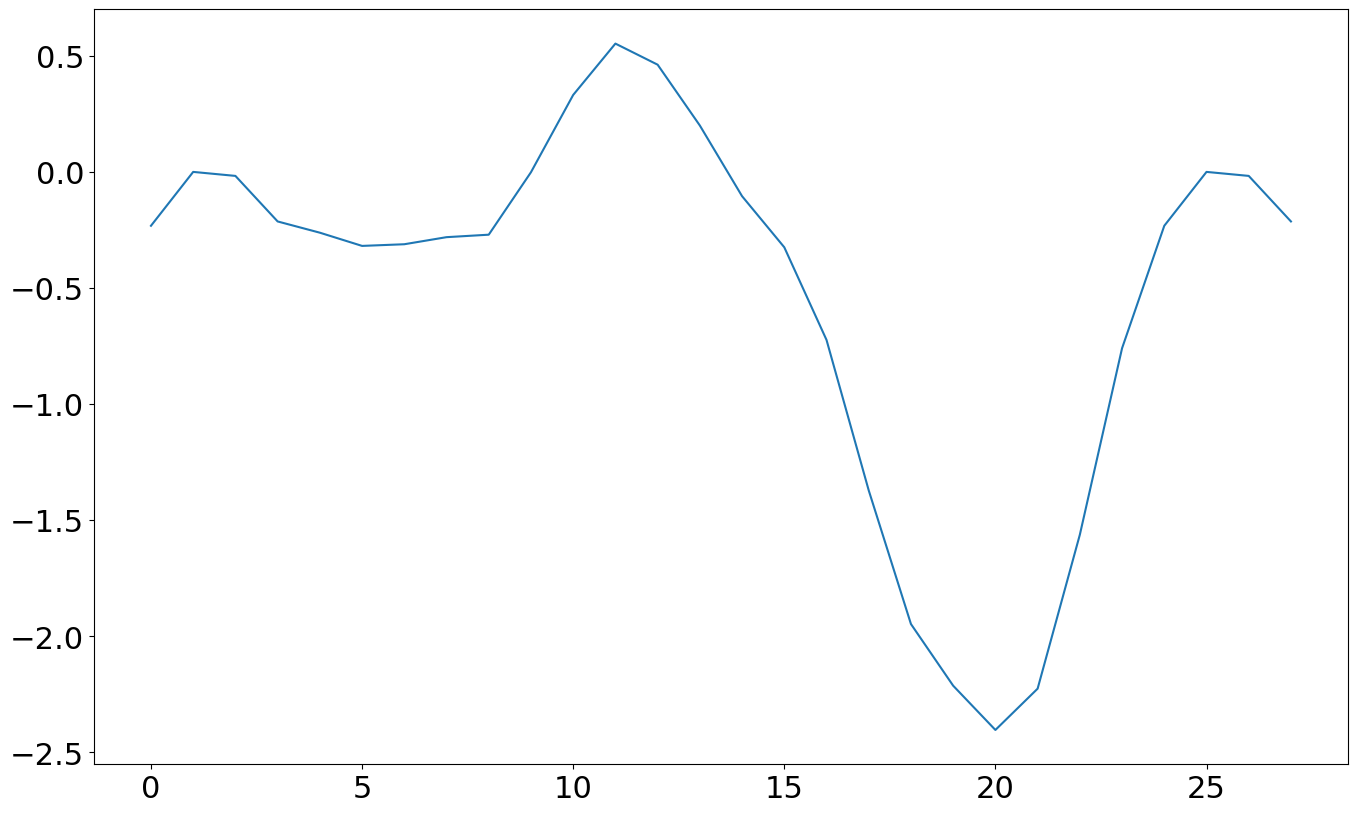

In [53]:
plt.plot(thetaspline[-5][61])

In [43]:
seq = "MNKKSKQQEKLYNFIIAKSFQQPVGSTFTYGELRKKYNVVCSTNDQREVGRRFAYWIKYTPGLPFKIVGTKNGSLLYQKIGINPC"

In [64]:
seq[80]

'G'

In [55]:
seq[61]

'G'

In [50]:
len(seq)

85